In [1]:
import pickle

import librosa.feature
import numpy as np
from keras import Input, Model
from keras.layers import Dense, Dropout
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy, CategoricalAccuracy
from keras.optimizers import Adam

from utilities.training_plots import plot_loss, plot_categorical_accuracy

2023-05-18 13:16:07.031947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define Feature Extraction

In [2]:
def get_feature(y, sr):
    mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)

    return np.concatenate((mfcc_mean, mfcc_min, mfcc_max))

## Make Training Data

In [3]:
def make_training_data(features_pickle):
    with open(features_pickle, 'rb') as f:
        xs, ys = pickle.load(f)
    total = len(xs)
    permutations = np.random.permutation(total)
    features = np.array(xs)[permutations]
    labels = np.array(ys)[permutations]
    features_train = features[0:700]
    labels_train = labels[0:700]
    features_validate = features[700:850]
    labels_validate = labels[700:850]
    features_test = features[850:total]
    labels_test = labels[850:total]
    data_set = (
        (labels_train, features_train),
        (labels_validate, features_validate),
        (labels_test, features_test)
    )
    with open('data_set.pkl', 'wb') as f:
        pickle.dump(data_set, f)

In [4]:
make_training_data('./features.pkl')

## Define Training Data Loader

In [5]:
def load_data():
    with open('data_set.pkl', 'rb') as f:
        data_set = pickle.load(f)

    return data_set

## Define Build Model, Train and Evaluate Model

In [10]:
def build_model():
    inputs = Input(shape=60, name="feature")
    x = Dense(40, activation="relu", name="dense_1")(inputs)
    x = Dense(20, activation="relu", name="dense_2")(x)
    outputs = Dense(10, activation="softmax", name="predictions")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(),
        loss=CategoricalCrossentropy(),
        metrics=[CategoricalAccuracy()],
    )
    model.summary()

    return model


def train(model, data_set):
    return model.fit(
        x=data_set[0][1].tolist(),
        y=data_set[0][0].tolist(),
        verbose=1,
        validation_data=(data_set[1][1].tolist(), data_set[1][0].tolist()),
        epochs=45
    )


def evaluate_model(model, data_set):
    return model.evaluate(x=data_set[2][1].tolist(), y=data_set[2][0].tolist(), verbose=0, return_dict=True)


## Load Training Data

In [11]:
data_set = load_data()

## Build Model

In [17]:
model = build_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature (InputLayer)        [(None, 60)]              0         
                                                                 
 dense_1 (Dense)             (None, 40)                2440      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 predictions (Dense)         (None, 10)                210       
                                                                 
Total params: 3,470
Trainable params: 3,470
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature (InputLayer)        [(None, 60)

## Train

In [18]:
history = train(model, data_set)

Epoch 1/45
22/22 [==============================] - 1s 10ms/step - loss: 12.3697 - categorical_accuracy: 0.0929 - val_loss: 6.7542 - val_categorical_accuracy: 0.1800
Epoch 2/45
22/22 [==============================] - 0s 3ms/step - loss: 5.7790 - categorical_accuracy: 0.1900 - val_loss: 4.3924 - val_categorical_accuracy: 0.1800
Epoch 3/45
22/22 [==============================] - 0s 3ms/step - loss: 3.6811 - categorical_accuracy: 0.2186 - val_loss: 2.9185 - val_categorical_accuracy: 0.2867
Epoch 4/45
22/22 [==============================] - 0s 4ms/step - loss: 2.5968 - categorical_accuracy: 0.2400 - val_loss: 2.2101 - val_categorical_accuracy: 0.3133
Epoch 5/45
22/22 [==============================] - 0s 3ms/step - loss: 2.1383 - categorical_accuracy: 0.3043 - val_loss: 2.0033 - val_categorical_accuracy: 0.3267
Epoch 6/45
22/22 [==============================] - 0s 3ms/step - loss: 1.9959 - categorical_accuracy: 0.3386 - val_loss: 1.9709 - val_categorical_accuracy: 0.3067
Epoch 7/45
22/

## Evaluate

In [19]:
evaluation = evaluate_model(model, data_set)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

loss: 1.6472
categorical_accuracy: 0.4228


## Plot Accuracy and Loss

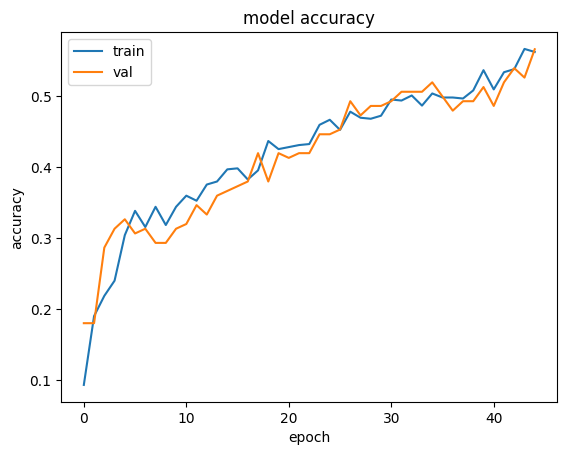

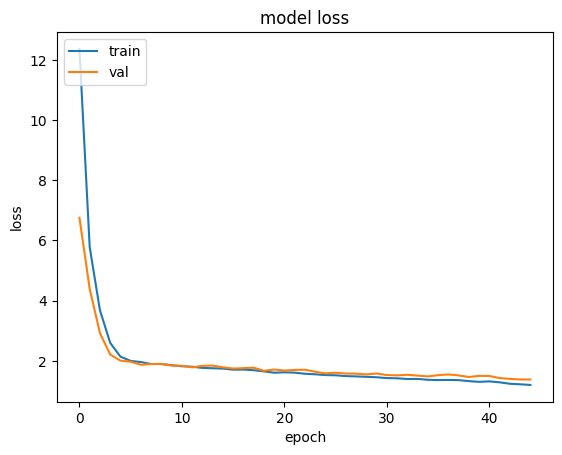

In [20]:
plot_categorical_accuracy(history)
plot_loss(history)
# plot_history(history)

## Save Model

In [21]:
model.save('../saved_models/random_forest_1')

INFO:tensorflow:Assets written to: ../saved_models/random_forest_1/assets
